In [1]:
from ultralytics import YOLO
import pandas as pd
import numpy as np
import time
import regex as re

import os
import joblib
import pickle
from joblib import dump, load
import matplotlib.pyplot as plt
# Set YOLOv8 to quiet mode
#os.environ['YOLO_VERBOSE'] = 'True'

filename = '/media/obafemi/New Volume1/ua-detrac/UA_DETRAC_zipped/test/DETRAC-test-data/Insight-MVT_Annotation_Test/finalized_reg_model.joblib'
model_speed = load(filename) 

/home/obafemi/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/obafemi/anaconda3/envs/ultralytics/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.1.3 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:
src = '/media/obafemi/New Volume1/mm_tracking/mmtracking/speed_est_ipynb_files/MVI_40793.mp4'


In [3]:
#ua detrac bus = 2, car = 0 , van = 1, others = 3
#yolo bus = 5, car = 2,  

In [46]:


def tracklets(src):
    model = YOLO("yolov8m.pt")

    results =model.track(source=src, conf=0.3, iou=0.5, show=False,verbose=False,stream=True)
    columns = ['frame_id','ids','bbox_x','bbox_y','area','labels','ids','x1','y1','x2','y2']
    dataframe = pd.DataFrame(columns = columns)

    for ind,r in enumerate(results):
        boxes = r.boxes.xywh.numpy()  # Boxes object for bbox outputs
        boxes_xyxy = r.boxes.xyxy.numpy()
        x1 ,y1, x2, y2 = boxes_xyxy[:,0], boxes_xyxy[:,1], boxes_xyxy[:,2], boxes_xyxy[:,3]
        frame = [ind+1]*len(boxes)
        x = boxes[:,0]
        y = boxes[:,1]
        area = boxes[:,2]*boxes[:,3]
        label = r.boxes.cls.numpy()
        ids = r.boxes.id.numpy()


        mini_df = pd.DataFrame(list(zip(frame,ids, x, y,area,label, ids,x1,y1,x2,y2)),columns = columns)
        dataframe = pd.concat([dataframe,mini_df])
    instances = len(dataframe)
    first_df = dataframe.iloc[:,:7]
    second_df = dataframe.iloc[:,7:]
    first_df['instances'], second_df['instances'] = np.arange(instances), np.arange(instances)  
    second_df['frame_num'] = first_df['frame_id']
    first_df['labels'] = first_df['labels'].replace([2, 5], [0,2])
    return first_df.values, second_df

In [47]:
def speed_dist(full_tracklets):    
    u_ids = np.unique(full_tracklets[:,1])

    complete_frame = np.zeros((1,10))
    for ind,i in enumerate(u_ids):

        dist = [] #distance empty array
        p_s = [] #pixel distance array
        tracklet = full_tracklets[np.where(i==full_tracklets[:,1])] # get the full path of a tracklet/object
        
      
        
        if len(tracklet)==1:
            d = 0
            s = 0
            dist.append(d)
            p_s.append(s)

            tracklet=np.column_stack((tracklet,dist,p_s))

            if ind==0:
                complete_frame = complete_frame+tracklet
            else:
                complete_frame = np.append(complete_frame,tracklet, axis=0)
            continue
        x_y_cen = tracklet[:,2:4] #the x and y coordinates

        for p in range(1,len(x_y_cen)):
            j=p-1
            d = np.linalg.norm(x_y_cen[p] - x_y_cen[j])
            s = (d*25)/2
            dist.append(d)
            p_s.append(s)


        dist.append(np.nan)
        p_s.append(np.nan)

        dist =np.array(dist)
        p_s = np.array(p_s)

        dist=pd.Series(dist)
        dist =dist.interpolate()
        dist = dist.values

        p_s=pd.Series(p_s)
        p_s =p_s.interpolate()
        p_s = p_s.values
        tracklet=np.column_stack((tracklet,dist,p_s))
        if ind==0:
            complete_frame = complete_frame+tracklet
        else:
            complete_frame = np.append(complete_frame,tracklet, axis=0)
        
    complete_frame = complete_frame[complete_frame[:, 7].argsort()]
    
    complete_frame = np.delete(complete_frame,[1,7],1)
    complete_frame[:,[5,6]] = complete_frame[:,[6,5]] 
    complete_frame[:,[6,7]] = complete_frame[:,[7,6]] 

    return complete_frame


def traffic_density_module(dataframe):
    a = dataframe.copy()

  
    import time
    road_lengths = []
    objects_ = []
    start= time.time()
  
    road_length_list = []

    print(df1)
    unique_id = dataframe['id'].unique()
    for id_ in unique_id:
        df_id = dataframe[dataframe['id']==id_]
        first_occurence = df_id.iloc[[0]]
        last_occurence = df_id.iloc[[-1]]
        coor_last = last_occurence[['x_center','y_center']].values
        coor_first = first_occurence[['x_center','y_center']].values
        max_dist = np.linalg.norm(coor_last - coor_first)
        road_length_list.append(max_dist)
    road_length = max(road_length_list)

    unique_frame = dataframe['frame_num'].unique()
    for frame_ind,frame in enumerate(unique_frame):
        df_frame = dataframe[dataframe['frame_num']==frame]
        object_count_per_frame = df_frame.shape[0]
        objects_.append(object_count_per_frame)
        ind_max = np.where(df_frame['area']==np.max(df_frame['area']))[0][0]
        #print(ind_max)
        ind_min = np.where(df_frame['area']==np.min(df_frame['area']))[0][0]
        #print(df_frame.iloc[ind_min,1:3].shape)
        road_len2 = np.linalg.norm(df_frame.iloc[ind_max,1:3] - df_frame.iloc[ind_min,1:3])
        #print(road_len2)
        


    zipped_vehicle_count = dict(zip(unique_frame,objects_))
    a['road length'] = road_length 
    a['vehicle count'] = a['frame_num'].map(zipped_vehicle_count)
    a['traffic density'] = a['vehicle count']/a['road length']
    a['traffic density2'] = a['vehicle count']/road_len2
    a = a.groupby('frame_num').mean()
    t_density= a['traffic density'].values
    t_density2= a['traffic density2'].values
    
    file_cluster = "/media/obafemi/New Volume1/mm_tracking/mmtracking/finalized_CLUS_model.joblib"
    model_cluster = load(file_cluster) 
    
    cluster = model_cluster.predict(t_density.reshape(-1,1))
    cluster2 = model_cluster.predict(t_density2.reshape(-1,1))
    
    cluster_mapping = ['Heavy','Medium','Medium','Light','Light','Light']
    cluster_num = [5,3,0,4,1,2]
    zipped_cluster = dict(zip(cluster_num,cluster_mapping))
    a['cluster_num'] = cluster
    a['cluster_num2'] = cluster2
    a['Traffic Density Cat'] =a['cluster_num'].map(zipped_cluster)
    a['Traffic Density Cat2'] =a['cluster_num2'].map(zipped_cluster)

    end= time.time()
    print(end-start) 
    
    return a


In [48]:
df1,_ = tracklets(src)
full_tracklets = df1
ans=speed_dist(full_tracklets)
ans_for_prediction = ans[:,[0,3,4,5,6,7]]
pred = model_speed.predict(ans_for_prediction)
cols1 = ["frame_num","x_center","y_center","area","class","pixel_dist","pixel_speed","id","pred","x1","y1","x2","y2"]
ans_check=np.column_stack((ans,pred,_.iloc[:,0] ,_.iloc[:,1],_.iloc[:,2], _.iloc[:,3] ))
df=pd.DataFrame(ans_check,columns = cols1)
df = traffic_density_module(df)

[[1 1.0 532.0855712890625 ... 0.0 1.0 0]
 [1 2.0 429.52569580078125 ... 0.0 2.0 1]
 [1 3.0 235.39540100097656 ... 0.0 3.0 2]
 ...
 [1960 1.0 647.8450927734375 ... 0.0 1.0 19541]
 [1960 2.0 186.11514282226562 ... 0.0 2.0 19542]
 [1960 3.0 364.73272705078125 ... 0.0 3.0 19543]]
3.9338161945343018


/home/obafemi/anaconda3/envs/ultralytics/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [49]:
_

,x1,y1,x2,y2,instances,frame_num
0,420.693909,317.060730,643.477173,447.644287,0,1
1,321.067871,279.124817,537.983521,395.904694,1,1
2,113.034393,290.226196,357.756409,394.484436,2,1
3,637.580078,325.111877,856.418945,473.359558,3,1
4,0.000000,387.319763,309.831543,536.095215,4,1
...,...,...,...,...,...,...
0,605.692139,141.182434,690.205688,203.077042,19539,1959
1,122.124146,112.912323,245.772247,160.166260,19540,1959
0,605.766602,140.995087,689.923584,202.861694,19541,1960
1,124.004333,112.944733,248.225952,162.342010,19542,1960


In [41]:
_.shape

(19544, 5)

In [18]:
df['ind'] = np.arange(1,len(df)+1)

In [34]:
df

,x_center,y_center,area,class,pixel_dist,pixel_speed,id,pred,x1,y1,...,y2,road length,vehicle count,traffic density,traffic density2,cluster_num,cluster_num2,Traffic Density Cat,Traffic Density Cat2,ind
frame_num,,,,,,,,,,,,,,,,,,,,,
1.0,560.798513,264.162811,15500.69438,0.071429,197.967426,2474.592829,7.5,197.967536,490.270101,219.653172,...,308.672447,788.129485,14.0,0.017764,0.075056,0,5,Medium,Heavy,1
2.0,567.192265,255.878544,14749.761507,0.066667,166.522296,2081.528703,8.0,166.522387,497.980503,213.212347,...,298.544738,788.129485,15.0,0.019032,0.080418,0,5,Medium,Heavy,2
3.0,583.864281,268.120286,16463.291128,0.076923,115.719123,1446.489036,7.0,115.719182,509.12383,223.606227,...,312.634341,788.129485,13.0,0.016495,0.069695,2,5,Light,Heavy,3
4.0,605.45031,264.264215,15448.423636,0.071429,104.863748,1310.796855,7.5,104.863801,534.774793,220.499327,...,308.029106,788.129485,14.0,0.017764,0.075056,0,5,Medium,Heavy,4
5.0,605.875814,264.465881,15368.857457,0.071429,121.294912,1516.186394,7.5,121.294974,535.310372,221.011491,...,307.920273,788.129485,14.0,0.017764,0.075056,0,5,Medium,Heavy,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956.0,413.24511,154.014786,5472.077637,0.0,3.142337,39.279214,1.5,3.142328,361.542938,126.84251,...,181.18705,788.129485,2.0,0.002538,0.010722,4,1,Light,Light,1956
1957.0,547.578156,122.836914,3755.088226,0.0,46.139749,576.746859,2.5,46.139767,511.68589,97.633847,...,148.039984,788.129485,4.0,0.005075,0.021445,4,0,Light,Medium,1957
1958.0,399.051615,130.938741,3782.09554,0.0,0.275046,3.43808,2.0,0.275036,362.691556,106.907995,...,154.969485,788.129485,3.0,0.003806,0.016084,4,2,Light,Light,1958


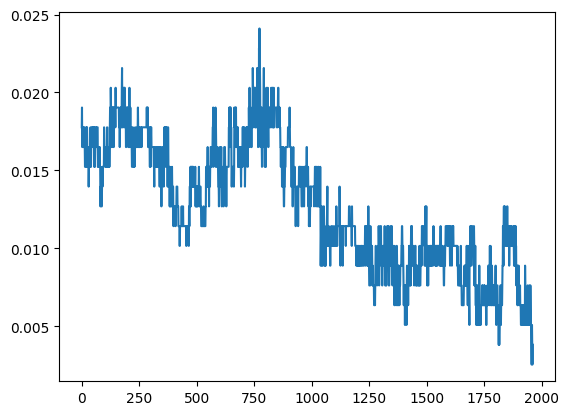

In [38]:
plt.plot(df['ind'],df['traffic density'])

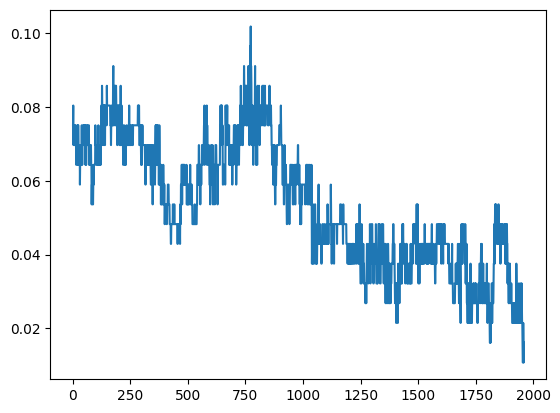

In [39]:
plt.plot(df['ind'],df['traffic density2'])

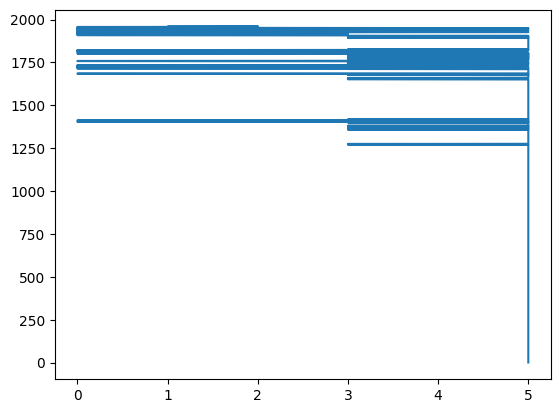

In [33]:
plt.plot(df['cluster_num2'].values, df['ind'].values)

In [29]:
df

,x_center,y_center,area,class,pixel_dist,pixel_speed,id,pred,x1,y1,...,y2,road length,vehicle count,traffic density,traffic density2,cluster_num,cluster_num2,Traffic Density Cat,Traffic Density Cat2,ind
frame_num,,,,,,,,,,,,,,,,,,,,,
1.0,560.798513,264.162811,15500.69438,0.071429,197.967426,2474.592829,7.5,197.967536,490.270101,219.653172,...,308.672447,788.129485,14.0,0.017764,0.075056,0,5,Medium,Heavy,1
2.0,567.192265,255.878544,14749.761507,0.066667,166.522296,2081.528703,8.0,166.522387,497.980503,213.212347,...,298.544738,788.129485,15.0,0.019032,0.080418,0,5,Medium,Heavy,2
3.0,583.864281,268.120286,16463.291128,0.076923,115.719123,1446.489036,7.0,115.719182,509.12383,223.606227,...,312.634341,788.129485,13.0,0.016495,0.069695,2,5,Light,Heavy,3
4.0,605.45031,264.264215,15448.423636,0.071429,104.863748,1310.796855,7.5,104.863801,534.774793,220.499327,...,308.029106,788.129485,14.0,0.017764,0.075056,0,5,Medium,Heavy,4
5.0,605.875814,264.465881,15368.857457,0.071429,121.294912,1516.186394,7.5,121.294974,535.310372,221.011491,...,307.920273,788.129485,14.0,0.017764,0.075056,0,5,Medium,Heavy,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956.0,413.24511,154.014786,5472.077637,0.0,3.142337,39.279214,1.5,3.142328,361.542938,126.84251,...,181.18705,788.129485,2.0,0.002538,0.010722,4,1,Light,Light,1956
1957.0,547.578156,122.836914,3755.088226,0.0,46.139749,576.746859,2.5,46.139767,511.68589,97.633847,...,148.039984,788.129485,4.0,0.005075,0.021445,4,0,Light,Medium,1957
1958.0,399.051615,130.938741,3782.09554,0.0,0.275046,3.43808,2.0,0.275036,362.691556,106.907995,...,154.969485,788.129485,3.0,0.003806,0.016084,4,2,Light,Light,1958


In [10]:
den = df[df[frame]]

,frame_num,x_center,y_center,area,class,pixel_dist,pixel_speed,id,pred,x1,...,x2,y2,road length,vehicle count,traffic density,traffic density2,cluster_num,cluster_num2,Traffic Density Cat,Traffic Density Cat2
0,1.0,532.085571,382.352509,29091.832031,0.0,0.816045,10.200566,1.0,0.81603,420.693909,...,643.477173,447.644287,788.129485,14,0.017764,0.075056,0,5,Medium,Heavy
1,1,429.525696,337.514771,25331.382812,0.0,0.424574,5.307171,2.0,0.424559,321.067871,...,537.983521,395.904694,788.129485,14,0.017764,0.075056,0,5,Medium,Heavy
2,1,235.395401,342.355316,25514.287109,0.0,0.033303,0.416287,3.0,0.033288,113.034393,...,357.756409,394.484436,788.129485,14,0.017764,0.075056,0,5,Medium,Heavy
3,1,746.999512,399.235718,32442.355469,0.0,0.789246,9.865576,4.0,0.78923,637.580078,...,856.418945,473.359558,788.129485,14,0.017764,0.075056,0,5,Medium,Heavy
4,1,154.915771,461.707489,46095.328125,0.0,138.862157,1735.776958,5.0,138.862222,0.0,...,309.831543,536.095215,788.129485,14,0.017764,0.075056,0,5,Medium,Heavy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19539,1959.0,647.948914,172.12973,5230.933105,0.0,0.226531,2.831642,1.0,0.226521,605.692139,...,690.205688,203.077042,788.129485,2,0.002538,0.010722,4,1,Light,Light
19540,1959,183.948196,136.539291,5842.859375,0.0,2.432005,30.400066,2.0,2.431996,122.124146,...,245.772247,160.16626,788.129485,2,0.002538,0.010722,4,1,Light,Light
19541,1960.0,647.845093,171.928391,5206.506836,0.0,0.226531,2.831642,1.0,0.226521,605.766602,...,689.923584,202.861694,788.129485,3,0.003806,0.016084,4,2,Light,Light
19542,1960,186.115143,137.643372,6136.209961,0.0,2.432005,30.400066,2.0,2.431996,124.004333,...,248.225952,162.34201,788.129485,3,0.003806,0.016084,4,2,Light,Light


In [84]:
pred

array([    0.81603,     0.42456,    0.033288, ...,     0.22652,       2.432,     0.13408])

In [74]:
pred

array([     143.29,      143.76,     0.10449, ...,      864.72,      375.66,      178.67])

In [42]:
pred

array([    0.81603,     0.42456,    0.033288, ...,     0.22652,       2.432,     0.13408])

In [43]:
df1

array([[1, 1.0, 532.0855712890625, ..., 2.0, 1.0, 0],
       [1, 2.0, 429.52569580078125, ..., 2.0, 2.0, 1],
       [1, 3.0, 235.39540100097656, ..., 2.0, 3.0, 2],
       ...,
       [1960, 1.0, 647.8450927734375, ..., 2.0, 1.0, 19541],
       [1960, 2.0, 186.11514282226562, ..., 2.0, 2.0, 19542],
       [1960, 3.0, 364.73272705078125, ..., 0.0, 3.0, 19543]], dtype=object)

In [239]:
speed_dist(df_tracks)

array([[1.0, 154.39471435546875, 459.9906921386719, ..., 142.99956855494767, 1787.494606936846, 1.0],
       [1, 235.6737060546875, 341.96807861328125, ..., 143.31429212744018, 1791.4286515930023, 2.0],
       [1, 428.93585205078125, 337.5174560546875, ..., 192.99936731158286, 2412.492091394786, 3.0],
       ...,
       [1959.0, 648.1356201171875, 170.57565307617188, ..., 0.3916579940736977, 4.895724925921222, 1.0],
       [1960.0, 647.9852294921875, 170.93728637695312, ..., 0.3916579940736977, 4.895724925921222, 1.0],
       [1960, 190.05880737304688, 134.5145263671875, ..., 8.139191385519688, 101.7398923189961, 2.0]], dtype=object)

In [47]:
model1 = YOLO("yolov8n.pt")
results1 = model1.track(source=src, conf=0.3, iou=0.5,  tracker="bytetrack.yaml",show=False,verbose=False,save=True)


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to runs/detect/track4


In [48]:
results1

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [160]:
#results[0].boxes
frame_ids = np.arange(1,len(results)+1)
bboxes = [results[i].boxes.xywh.numpy()   for i in range(len(results))]
bbox_x = [results[i].boxes.xywh.numpy()[:,0]   for i in range(len(results))]
bbox_y = [results[i].boxes.xywh.numpy()[:,1]   for i in range(len(results))]
ids = [results[i].boxes.id.numpy()   for i in range(len(results))]
labels = [results[i].boxes.cls.numpy()   for i in range(len(results))]
areas = [bboxes[i][:, 2]*bboxes[i][:, 3]  for i in range(len(results))]


In [161]:
columns = ['frame_id','ids','bbox_x','bbox_y','area','labels','ids']
dataframe = pd.DataFrame(columns = columns)
for i in range(len(results)):
    x = bbox_x[i]
    y = bbox_y[i]
    label = labels[i]
    id_ = ids[i]
    area = areas[i]
    frames = [i+1]*len(area)
    mini_df = pd.DataFrame(list(zip(frames,id_, x, y,area,label, id_)),columns = columns)
    dataframe = pd.concat([dataframe,mini_df])
    

In [163]:
dataframe

,frame_id,ids,bbox_x,bbox_y,area,labels,ids
0,1,1.0,154.394714,459.990692,46332.039062,2.0,1.0
1,1,2.0,235.673706,341.968079,25320.496094,2.0,2.0
2,1,3.0,428.935852,337.517456,25104.970703,2.0,3.0
3,1,4.0,531.136169,382.920227,29701.667969,2.0,4.0
4,1,5.0,305.900940,483.825134,30918.503906,2.0,5.0
...,...,...,...,...,...,...,...
0,1958,1.0,648.134888,170.869110,5198.516113,2.0,1.0
1,1958,2.0,182.257401,136.834976,6657.472168,2.0,2.0
0,1959,1.0,648.135620,170.575653,5227.826172,2.0,1.0
0,1960,1.0,647.985229,170.937286,5365.865234,2.0,1.0


In [11]:
a = np.arange(4)

In [12]:
a[1:3]

array([1, 2])

In [45]:
model1 = YOLO("yolov8m.pt")
model1.track?

In [46]:
results

NameError: name 'results' is not defined